In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel # Using AutoModel for embeddings
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import joblib

from wordcloud import WordCloud
from collections import Counter

In [2]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

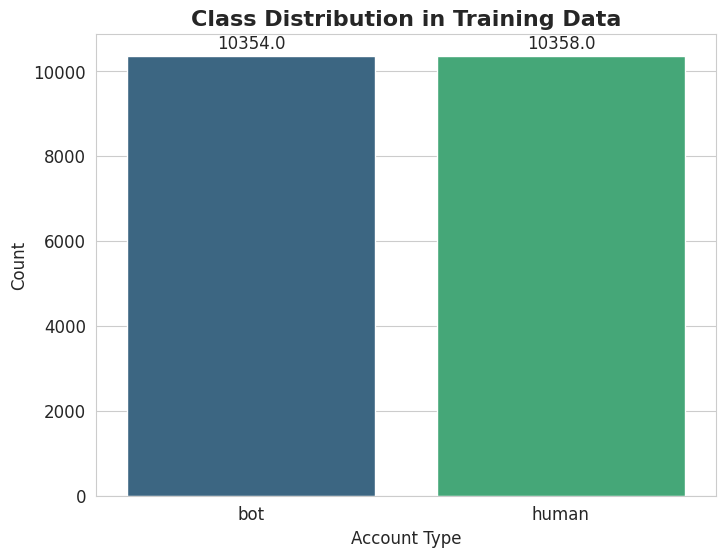

In [3]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

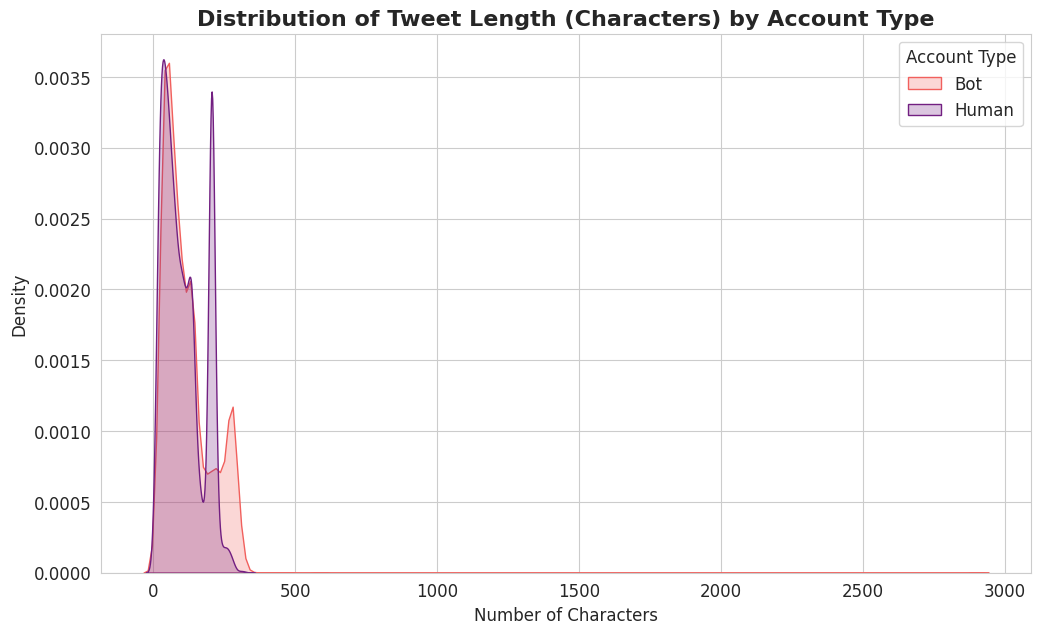

In [4]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

In [5]:
df_bots = df[df['account.type'] == 'bot']
df_bots.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2,92


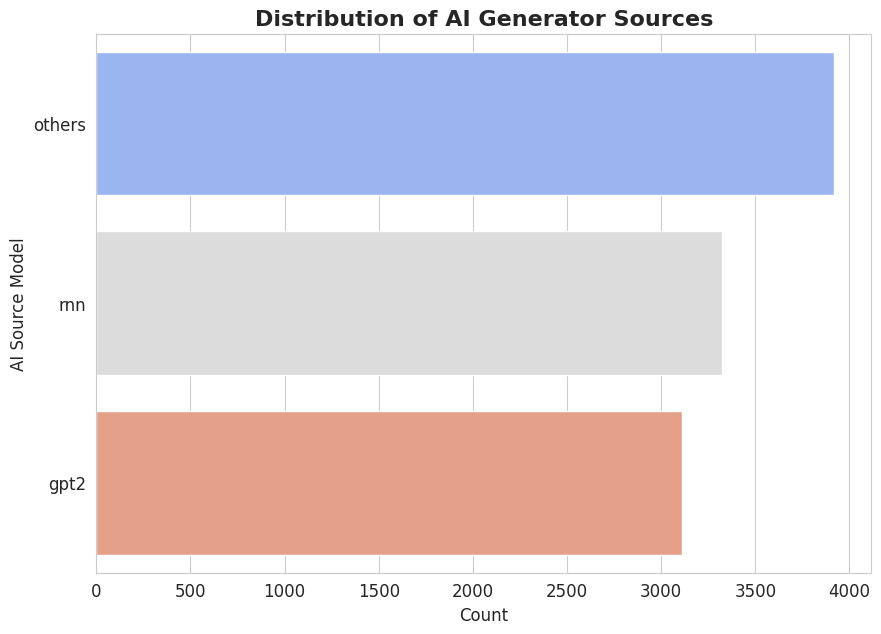

In [6]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [7]:
# --- 0. Configuration & Seeding ---
SEED = 42
ROBERTA_MODEL_NAME = "roberta-base"
MAX_LEN_ROBERTA = 128
BATCH_SIZE = 16
EPOCHS_CNN_EXTRA_HYBRID = 4 # Start with similar to RoBERTa+CNN
LEARNING_RATE_CNN_EXTRA_HYBRID = 2e-5
NUM_CNN_FILTERS = 100
CNN_KERNEL_SIZES = [3, 4, 5]
CNN_EXTRA_DROPOUT_RATE = 0.3 # Dropout for CNN and final classifier
OUTPUT_DIR_ROBERTA_CNN_EXTRA = "./roberta_cnn_extra_output"

BEST_MODEL_PATH = os.path.join(OUTPUT_DIR_ROBERTA_CNN_EXTRA, "best_roberta_cnn_extra_model.pt")
TOKENIZER_PATH = os.path.join(OUTPUT_DIR_ROBERTA_CNN_EXTRA, "tokenizer")
SCALER_PATH = os.path.join(OUTPUT_DIR_ROBERTA_CNN_EXTRA, "scaler.pkl")

if not os.path.exists(OUTPUT_DIR_ROBERTA_CNN_EXTRA):
    os.makedirs(OUTPUT_DIR_ROBERTA_CNN_EXTRA)

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [8]:
# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# --- 2. Load Data (Assuming df_train_orig, df_val_orig, df_test_orig are loaded) ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

In [10]:
# --- 3. Basic Text Cleaning ---
def clean_text_for_roberta(text):
    text = str(text); text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text); text = text.lower().strip()
    return text

df_train_orig['processed_text'] = df_train_orig['text'].apply(clean_text_for_roberta)
df_val_orig['processed_text'] = df_val_orig['text'].apply(clean_text_for_roberta)
df_test_orig['processed_text'] = df_test_orig['text'].apply(clean_text_for_roberta)

In [11]:
# --- 4. Label Encoding ---
label_mapping = {'human': 0, 'bot': 1}
num_labels_cnn_extra = len(label_mapping)
df_train_orig['label_encoded'] = df_train_orig['account.type'].map(label_mapping)
df_val_orig['label_encoded'] = df_val_orig['account.type'].map(label_mapping)
df_test_orig['label_encoded'] = df_test_orig['account.type'].map(label_mapping)

df_train_orig = df_train_orig[df_train_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_val_orig = df_val_orig[df_val_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_test_orig = df_test_orig[df_test_orig['processed_text'].str.strip() != ""].reset_index(drop=True)

In [12]:
# --- 5. RoBERTa Tokenizer ---
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_MODEL_NAME)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
# --- 6. Tokenization Function ---
def tokenize_data_roberta(texts, labels, tokenizer, max_len):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    return encodings, torch.tensor(labels.values, dtype=torch.long)

train_encodings_cnn_extra, train_labels_cnn_extra = tokenize_data_roberta(df_train_orig['processed_text'], df_train_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
val_encodings_cnn_extra, val_labels_cnn_extra = tokenize_data_roberta(df_val_orig['processed_text'], df_val_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
test_encodings_cnn_extra, test_labels_cnn_extra = tokenize_data_roberta(df_test_orig['processed_text'], df_test_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)

In [14]:
# --- 7. EXTRA FEATURE ENGINEERING (reuse from RoBERTa-Only + Extra) ---
print("\nReusing Extra Feature Engineering...")
def extract_manual_features(df_text_col, df_screen_name_col, df_original_text_col):
    features_list = []; # ... (Same function definition as before) ...
    for text_cleaned, screen_name, text_original in zip(df_text_col, df_screen_name_col, df_original_text_col):
        raw_text = str(text_original); num_urls = len(re.findall(r'http\S+', raw_text))
        num_mentions = len(re.findall(r'@\w+', raw_text)); num_hashtags = len(re.findall(r'#\w+', raw_text))
        words = str(text_cleaned).split(); num_words = len(words); num_characters = len(str(text_cleaned))
        avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        num_digits_text = sum(c.isdigit() for c in str(text_cleaned))
        num_uppercase_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        sn = str(screen_name); sn_length = len(sn); sn_num_digits = sum(c.isdigit() for c in sn)
        sn_has_bot = 1 if 'bot' in sn.lower() else 0
        features_list.append([
            num_characters, num_words, avg_word_length, num_urls, num_mentions, num_hashtags,
            num_digits_text, num_uppercase_words, sn_length, sn_num_digits, sn_has_bot
        ])
    return np.array(features_list)

train_extra_features_np = extract_manual_features(df_train_orig['processed_text'], df_train_orig['screen_name'], df_train_orig['text'])
val_extra_features_np = extract_manual_features(df_val_orig['processed_text'], df_val_orig['screen_name'], df_val_orig['text'])
test_extra_features_np = extract_manual_features(df_test_orig['processed_text'], df_test_orig['screen_name'], df_test_orig['text'])

scaler = StandardScaler()
train_extra_features_scaled_np = scaler.fit_transform(train_extra_features_np)
val_extra_features_scaled_np = scaler.transform(val_extra_features_np)
test_extra_features_scaled_np = scaler.transform(test_extra_features_np)

num_extra_features = train_extra_features_scaled_np.shape[1]
print(f"Number of extra manual features: {num_extra_features}")
train_extra_features_tensor = torch.tensor(train_extra_features_scaled_np, dtype=torch.float)
val_extra_features_tensor = torch.tensor(val_extra_features_scaled_np, dtype=torch.float)
test_extra_features_tensor = torch.tensor(test_extra_features_scaled_np, dtype=torch.float)


Reusing Extra Feature Engineering...
Number of extra manual features: 11


In [15]:
# --- 8. Create TensorDatasets and DataLoaders (with RoBERTa tokens AND extra features) ---
train_dataset_cnn_extra = TensorDataset(
    train_encodings_cnn_extra['input_ids'], train_encodings_cnn_extra['attention_mask'],
    train_extra_features_tensor, train_labels_cnn_extra
)
val_dataset_cnn_extra = TensorDataset(
    val_encodings_cnn_extra['input_ids'], val_encodings_cnn_extra['attention_mask'],
    val_extra_features_tensor, val_labels_cnn_extra
)
test_dataset_cnn_extra = TensorDataset(
    test_encodings_cnn_extra['input_ids'], test_encodings_cnn_extra['attention_mask'],
    test_extra_features_tensor, test_labels_cnn_extra
)

train_dataloader_cnn_extra = DataLoader(train_dataset_cnn_extra, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader_cnn_extra = DataLoader(val_dataset_cnn_extra, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader_cnn_extra = DataLoader(test_dataset_cnn_extra, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders for RoBERTa+CNN+Extra created.")

DataLoaders for RoBERTa+CNN+Extra created.


In [16]:
# --- 9. Model Definition: RoBERTa + CNN + Extra Features ---
class RobertaCNNExtraModel(nn.Module):
    def __init__(self, roberta_model_name, num_classes, num_cnn_filters, 
                 cnn_kernel_sizes, cnn_dropout_rate, num_extra_features): # Added num_extra_features
        super(RobertaCNNExtraModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=roberta_output_dim, out_channels=num_cnn_filters, kernel_size=ks)
            for ks in cnn_kernel_sizes
        ])
        
        cnn_output_dim = len(cnn_kernel_sizes) * num_cnn_filters
        classifier_input_dim = cnn_output_dim + num_extra_features # Add extra features to CNN output

        self.dropout_cnn_output = nn.Dropout(cnn_dropout_rate) # Dropout after CNN pooling
        self.dropout_final = nn.Dropout(cnn_dropout_rate)     # Dropout before final classifier
        self.classifier = nn.Linear(classifier_input_dim, num_classes)

    def forward(self, input_ids, attention_mask, extra_features, labels=None): # Added extra_features
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = roberta_outputs.last_hidden_state
        
        embedded_permuted = sequence_output.permute(0, 2, 1)
        
        conved = [F.relu(conv(embedded_permuted)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conved]
        
        cnn_cat_output = torch.cat(pooled, dim=1)
        cnn_cat_output_dropped = self.dropout_cnn_output(cnn_cat_output) # Dropout CNN features

        # Concatenate CNN output with extra features
        combined_representation = torch.cat((cnn_cat_output_dropped, extra_features), dim=1)
        
        final_dropped_features = self.dropout_final(combined_representation)
        logits = self.classifier(final_dropped_features)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model_roberta_cnn_extra = RobertaCNNExtraModel(
    roberta_model_name=ROBERTA_MODEL_NAME,
    num_classes=num_labels_cnn_extra,
    num_cnn_filters=NUM_CNN_FILTERS,
    cnn_kernel_sizes=CNN_KERNEL_SIZES,
    cnn_dropout_rate=CNN_EXTRA_DROPOUT_RATE,
    num_extra_features=num_extra_features # Pass this
).to(device)
print("RoBERTa + CNN + Extra Features model defined.")

2025-06-08 04:18:58.703271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749356339.160225      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749356339.271699      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa + CNN + Extra Features model defined.


In [17]:
# --- 10. Optimizer ---
optimizer_roberta_cnn_extra = AdamW(model_roberta_cnn_extra.parameters(), lr=LEARNING_RATE_CNN_EXTRA_HYBRID)

In [18]:
# --- 11. Training Loop (CORRECTED DEFINITION for models with extra features) ---
def train_model_with_extra_feats(model, train_loader, val_loader, optimizer, device, epochs, 
                                 model_save_path_base_dir, # CHANGED: Directory for saving
                                 model_name_prefix,        # CHANGED: Prefix for model file name
                                 experiment_name_suffix=""):
    criterion = nn.CrossEntropyLoss() # Fallback if model doesn't return loss
    best_val_f1 = 0.0
    best_model_path = "" # Will store the full path to the best model
    history = {'epoch': [], 'train_avg_loss': [], 'val_avg_loss': [], 'val_f1_score': [], 'val_accuracy': []}

    # Ensure the save directory exists
    if not os.path.exists(model_save_path_base_dir):
        os.makedirs(model_save_path_base_dir)
        print(f"Created directory: {model_save_path_base_dir}")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [{experiment_name_suffix} Train]", leave=False)

        for batch in train_progress_bar:
            optimizer.zero_grad()
            # Batch structure for "with_extra_feats" is (input_ids, attention_mask, extra_feats, labels)
            input_ids, attention_mask, extra_feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

            # Pass all inputs to the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_features=extra_feats, labels=labels)
            
            # Check if loss is directly provided by the model (Hugging Face style)
            if isinstance(outputs, dict) and "loss" in outputs and outputs["loss"] is not None:
                loss = outputs["loss"]
            else: # Fallback: if model only returns logits, calculate loss
                logits = outputs["logits"] if isinstance(outputs, dict) else outputs 
                loss = criterion(logits, labels)
            
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - {experiment_name_suffix} Train Avg Loss: {avg_train_loss:.4f}")

        # Validation step
        # Ensure evaluate_model_with_extra_feats is defined and matches expected return values
        val_accuracy, val_f1, avg_val_loss = evaluate_model_with_extra_feats(
            model, val_loader, device, f"{experiment_name_suffix} Validation Epoch {epoch+1}"
        )
        
        history['epoch'].append(epoch + 1)
        history['train_avg_loss'].append(avg_train_loss)
        history['val_avg_loss'].append(avg_val_loss)
        history['val_f1_score'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Construct the full path for saving the model
            current_model_save_path = os.path.join(model_save_path_base_dir, f"{model_name_prefix}_epoch{epoch+1}_f1_{val_f1:.4f}.pt")
            torch.save(model.state_dict(), current_model_save_path)
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            best_model_path = current_model_save_path # Update the path to the best model found so far
            print(f"New best F1: {best_val_f1:.4f}. Model saved to {best_model_path}")

    history_df = pd.DataFrame(history)
    print(f"Training complete for {experiment_name_suffix}. Best validation F1: {best_val_f1:.4f} from {best_model_path}")
    return best_model_path, history_df

In [19]:
# --- 12. Evaluation Function (MODIFIED for models with extra features) ---
def evaluate_model_with_extra_feats(model, dataloader, device, dataset_name="Dataset"):
    criterion = nn.CrossEntropyLoss() # Fallback
    model.eval()
    all_preds, all_labels, total_eval_loss = [], [], 0

    with torch.no_grad():
        eval_progress_bar = tqdm(dataloader, desc=f"Evaluating on {dataset_name}", leave=False)
        for batch in eval_progress_bar:
            input_ids, attention_mask, extra_feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_features=extra_feats, labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]
            total_eval_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_eval_loss = total_eval_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n--- {dataset_name} Results ---"); print(f"Avg Loss: {avg_eval_loss:.4f}"); print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}"); print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()));
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'{dataset_name} Confusion Matrix'); plt.show()
    return accuracy, f1, avg_eval_loss

In [20]:
# --- 12. Run RoBERTa + CNN + Extra Features Experiment ---
print("\n\n--- Starting Experiment 4.1: RoBERTa + CNN + Extra Features ---")



--- Starting Experiment 4.1: RoBERTa + CNN + Extra Features ---


Epoch 1/4 [RoBERTa-CNN-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 1 - RoBERTa-CNN-Extra Train Avg Loss: 0.3950


Evaluating on RoBERTa-CNN-Extra Validation Epoch 1:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN-Extra Validation Epoch 1 Results ---
Avg Loss: 0.3208
Accuracy: 0.8597
F1-Score (Weighted): 0.8592
              precision    recall  f1-score   support

       human       0.82      0.92      0.87      1143
         bot       0.91      0.80      0.85      1152

    accuracy                           0.86      2295
   macro avg       0.86      0.86      0.86      2295
weighted avg       0.86      0.86      0.86      2295



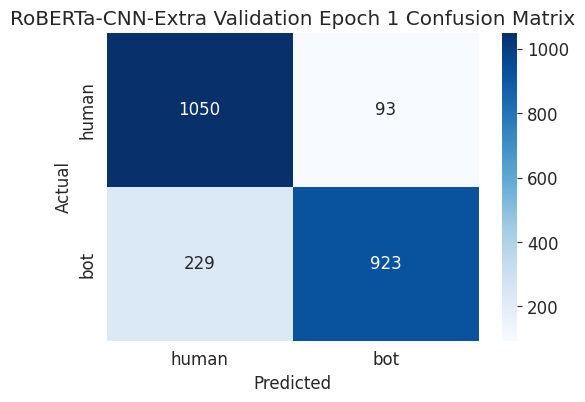

New best F1: 0.8592. Model saved to ./roberta_cnn_extra_output/roberta_cnn_extra_epoch1_f1_0.8592.pt


Epoch 2/4 [RoBERTa-CNN-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 2 - RoBERTa-CNN-Extra Train Avg Loss: 0.2648


Evaluating on RoBERTa-CNN-Extra Validation Epoch 2:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN-Extra Validation Epoch 2 Results ---
Avg Loss: 0.3058
Accuracy: 0.8497
F1-Score (Weighted): 0.8478
              precision    recall  f1-score   support

       human       0.78      0.96      0.86      1143
         bot       0.95      0.74      0.83      1152

    accuracy                           0.85      2295
   macro avg       0.87      0.85      0.85      2295
weighted avg       0.87      0.85      0.85      2295



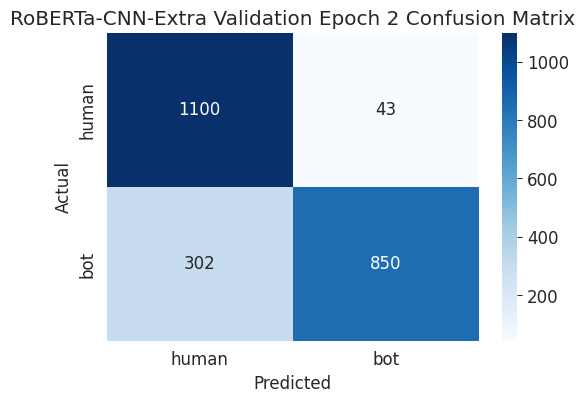

Epoch 3/4 [RoBERTa-CNN-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 3 - RoBERTa-CNN-Extra Train Avg Loss: 0.1791


Evaluating on RoBERTa-CNN-Extra Validation Epoch 3:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN-Extra Validation Epoch 3 Results ---
Avg Loss: 0.2849
Accuracy: 0.8898
F1-Score (Weighted): 0.8897
              precision    recall  f1-score   support

       human       0.87      0.91      0.89      1143
         bot       0.91      0.87      0.89      1152

    accuracy                           0.89      2295
   macro avg       0.89      0.89      0.89      2295
weighted avg       0.89      0.89      0.89      2295



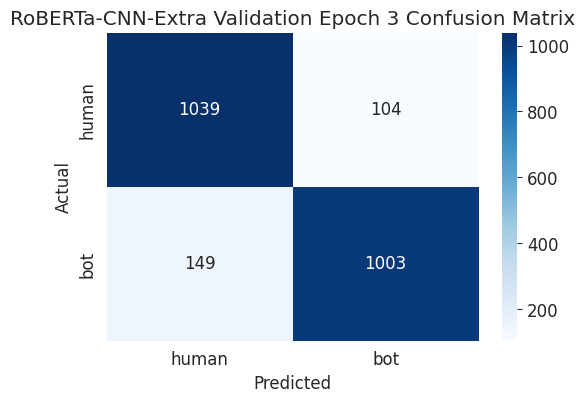

New best F1: 0.8897. Model saved to ./roberta_cnn_extra_output/roberta_cnn_extra_epoch3_f1_0.8897.pt


Epoch 4/4 [RoBERTa-CNN-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 4 - RoBERTa-CNN-Extra Train Avg Loss: 0.1126


Evaluating on RoBERTa-CNN-Extra Validation Epoch 4:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-CNN-Extra Validation Epoch 4 Results ---
Avg Loss: 0.3552
Accuracy: 0.8671
F1-Score (Weighted): 0.8671
              precision    recall  f1-score   support

       human       0.86      0.87      0.87      1143
         bot       0.87      0.86      0.87      1152

    accuracy                           0.87      2295
   macro avg       0.87      0.87      0.87      2295
weighted avg       0.87      0.87      0.87      2295



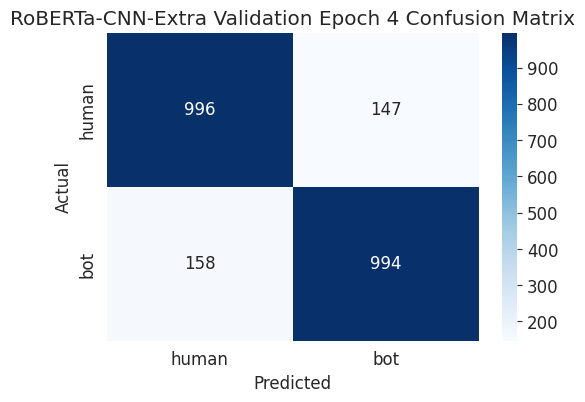

Training complete for RoBERTa-CNN-Extra. Best validation F1: 0.8897 from ./roberta_cnn_extra_output/roberta_cnn_extra_epoch3_f1_0.8897.pt

RoBERTa-CNN + Extra Features Training History:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.394959      0.320768      0.859233      0.859695
1      2        0.264816      0.305784      0.847803      0.849673
2      3        0.179085      0.284864      0.889726      0.889760
3      4        0.112582      0.355228      0.867102      0.867102

Loading best RoBERTa-CNN-Extra model from: ./roberta_cnn_extra_output/roberta_cnn_extra_epoch3_f1_0.8897.pt

--- Testing RoBERTa + CNN + Extra Features on Test Set ---


Evaluating on RoBERTa-CNN-Extra Test:   0%|          | 0/160 [00:00<?, ?it/s]


--- RoBERTa-CNN-Extra Test Results ---
Avg Loss: 0.2962
Accuracy: 0.8769
F1-Score (Weighted): 0.8768
              precision    recall  f1-score   support

       human       0.86      0.90      0.88      1270
         bot       0.89      0.86      0.87      1280

    accuracy                           0.88      2550
   macro avg       0.88      0.88      0.88      2550
weighted avg       0.88      0.88      0.88      2550



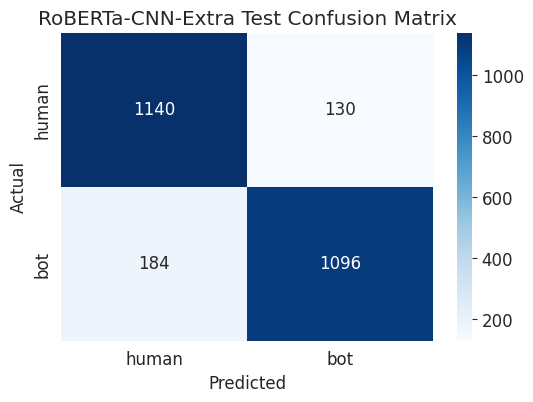

RoBERTa-CNN-Extra Test Set - Accuracy: 0.8769, F1: 0.8768, Loss: 0.2962


In [21]:
best_cnn_extra_model_path, cnn_extra_training_history_df = train_model_with_extra_feats(
    model_roberta_cnn_extra,
    train_dataloader_cnn_extra,
    val_dataloader_cnn_extra,
    optimizer_roberta_cnn_extra,
    device,
    epochs=EPOCHS_CNN_EXTRA_HYBRID,
    model_save_path_base_dir=OUTPUT_DIR_ROBERTA_CNN_EXTRA, # Pass output directory
    model_name_prefix="roberta_cnn_extra",         # Pass model name prefix
    experiment_name_suffix="RoBERTa-CNN-Extra"
)

print("\nRoBERTa-CNN + Extra Features Training History:")
print(cnn_extra_training_history_df)
# Plot history...

if best_cnn_extra_model_path and os.path.exists(best_cnn_extra_model_path):
    print(f"\nLoading best RoBERTa-CNN-Extra model from: {best_cnn_extra_model_path}")
    model_roberta_cnn_extra.load_state_dict(torch.load(best_cnn_extra_model_path))
else:
    print("No best model for RoBERTa-CNN-Extra was saved/found. Evaluating with the last state.")

print("\n--- Testing RoBERTa + CNN + Extra Features on Test Set ---")
test_acc_cnn_extra, test_f1_cnn_extra, test_loss_cnn_extra = evaluate_model_with_extra_feats(
    model_roberta_cnn_extra, test_dataloader_cnn_extra, device, "RoBERTa-CNN-Extra Test"
)
print(f"RoBERTa-CNN-Extra Test Set - Accuracy: {test_acc_cnn_extra:.4f}, F1: {test_f1_cnn_extra:.4f}, Loss: {test_loss_cnn_extra:.4f}")

In [22]:
print("\n--- Saving final components for XAI ---")

# The tokenizer was defined in cell #10 as 'tokenizer_roberta'
tokenizer_roberta.save_pretrained(TOKENIZER_PATH)
print(f"Tokenizer saved to: {TOKENIZER_PATH}")

# The scaler was defined in cell #12 as 'scaler'
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to: {SCALER_PATH}")

print("\n--- Artifacts saved successfully! ---")


--- Saving final components for XAI ---
Tokenizer saved to: ./roberta_cnn_extra_output/tokenizer
Scaler saved to: ./roberta_cnn_extra_output/scaler.pkl

--- Artifacts saved successfully! ---


In [23]:
# Cleanup
del model_roberta_cnn_extra, optimizer_roberta_cnn_extra
del train_dataloader_cnn_extra, val_dataloader_cnn_extra, test_dataloader_cnn_extra
# Keep train_extra_features_tensor etc. if you plan more "extra feature" experiments immediately
torch.cuda.empty_cache()

In [24]:
!pip install lime
!pip install shap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
# Cell 1: Setup and Loading Artifacts
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import joblib
import os
import re

# --- Define the Model Architecture (This must match the saved model) ---
class RobertaCNNExtraModel(nn.Module):
    def __init__(self, roberta_model_name, num_classes, num_cnn_filters, 
                 cnn_kernel_sizes, cnn_dropout_rate, num_extra_features):
        super(RobertaCNNExtraModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=roberta_output_dim, out_channels=num_cnn_filters, kernel_size=ks)
            for ks in cnn_kernel_sizes
        ])
        cnn_output_dim = len(cnn_kernel_sizes) * num_cnn_filters
        classifier_input_dim = cnn_output_dim + num_extra_features
        self.dropout_cnn_output = nn.Dropout(cnn_dropout_rate)
        self.dropout_final = nn.Dropout(cnn_dropout_rate)
        self.classifier = nn.Linear(classifier_input_dim, num_classes)

    def forward(self, input_ids, attention_mask, extra_features, labels=None):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = roberta_outputs.last_hidden_state
        embedded_permuted = sequence_output.permute(0, 2, 1)
        conved = [F.relu(conv(embedded_permuted)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conved]
        cnn_cat_output = torch.cat(pooled, dim=1)
        cnn_cat_output_dropped = self.dropout_cnn_output(cnn_cat_output)
        combined_representation = torch.cat((cnn_cat_output_dropped, extra_features), dim=1)
        final_dropped_features = self.dropout_final(combined_representation)
        logits = self.classifier(final_dropped_features)
        
        # We don't need the loss calculation for inference, but returning a dict is good practice
        return {"logits": logits}

# --- Define paths to your saved artifacts ---
OUTPUT_DIR = "./roberta_cnn_extra_output"
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, "best_roberta_cnn_extra_model.pt")
TOKENIZER_SAVE_PATH = os.path.join(OUTPUT_DIR, "tokenizer")
SCALER_SAVE_PATH = os.path.join(OUTPUT_DIR, "scaler.pkl")

# --- Load the artifacts ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_SAVE_PATH)

print("Loading scaler...")
scaler = joblib.load(SCALER_SAVE_PATH)
num_extra_features = scaler.n_features_in_

print("Loading model...")
model_roberta_cnn_extra = RobertaCNNExtraModel(
    roberta_model_name="roberta-base", # This can be a base name, as weights are loaded next
    num_classes=2,
    num_cnn_filters=100,
    cnn_kernel_sizes=[3, 4, 5],
    cnn_dropout_rate=0.3,
    num_extra_features=num_extra_features
)
model_roberta_cnn_extra.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model_roberta_cnn_extra.to(device)
model_roberta_cnn_extra.eval() # Set model to evaluation mode

print("\n--- All components loaded and ready for analysis! ---")

Loading tokenizer...
Loading scaler...
Loading model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- All components loaded and ready for analysis! ---


In [26]:
# Cell 2: LIME Implementation
# !pip install lime
import lime
import lime.lime_text

# --- Helper functions for feature extraction ---
def extract_manual_features(df_text_col, df_screen_name_col, df_original_text_col):
    # This is your original feature extraction function
    features_list = []
    for text_cleaned, screen_name, text_original in zip(df_text_col, df_screen_name_col, df_original_text_col):
        raw_text = str(text_original); num_urls = len(re.findall(r'http\\S+', raw_text))
        num_mentions = len(re.findall(r'@\\w+', raw_text)); num_hashtags = len(re.findall(r'#\\w+', raw_text))
        words = str(text_cleaned).split(); num_words = len(words); num_characters = len(str(text_cleaned))
        avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        num_digits_text = sum(c.isdigit() for c in str(text_cleaned))
        num_uppercase_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        sn = str(screen_name); sn_length = len(sn); sn_num_digits = sum(c.isdigit() for c in sn)
        sn_has_bot = 1 if 'bot' in sn.lower() else 0
        features_list.append([
            num_characters, num_words, avg_word_length, num_urls, num_mentions, num_hashtags,
            num_digits_text, num_uppercase_words, sn_length, sn_num_digits, sn_has_bot
        ])
    return np.array(features_list)

# --- Prediction function for LIME ---
def lime_predictor(texts):
    model_roberta_cnn_extra.eval()
    
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    
    dummy_df = pd.DataFrame({'processed_text': texts, 'screen_name': ['default_sn'] * len(texts), 'text': texts})
    extra_features_np = extract_manual_features(dummy_df['processed_text'], dummy_df['screen_name'], dummy_df['text'])
    scaled_features = scaler.transform(extra_features_np)
    extra_features_tensor = torch.tensor(scaled_features, dtype=torch.float).to(device)

    with torch.no_grad():
        logits = model_roberta_cnn_extra(input_ids, attention_mask, extra_features_tensor)["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# --- Explain an instance ---
explainer = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

print("--- Explaining a BOT-like tweet ---")
explanation_bot = explainer.explain_instance(text_to_explain_bot, lime_predictor, num_features=10, labels=(1,))
explanation_bot.save_to_file(os.path.join(OUTPUT_DIR, 'lime_bot_explanation.html'))
explanation_bot.show_in_notebook(text=True)

print("\n--- Explaining a HUMAN-like tweet ---")
explanation_human = explainer.explain_instance(text_to_explain_human, lime_predictor, num_features=10, labels=(0,))
explanation_human.save_to_file(os.path.join(OUTPUT_DIR, 'lime_human_explanation.html'))
explanation_human.show_in_notebook(text=True)

--- Explaining a BOT-like tweet ---



--- Explaining a HUMAN-like tweet ---


Getting RoBERTa Embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Getting RoBERTa Embeddings:   0%|          | 0/20 [00:00<?, ?it/s]


Calculating SHAP values... (this may take a while)


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values calculated.

--- Generating SHAP Global Feature Importance Plot ---


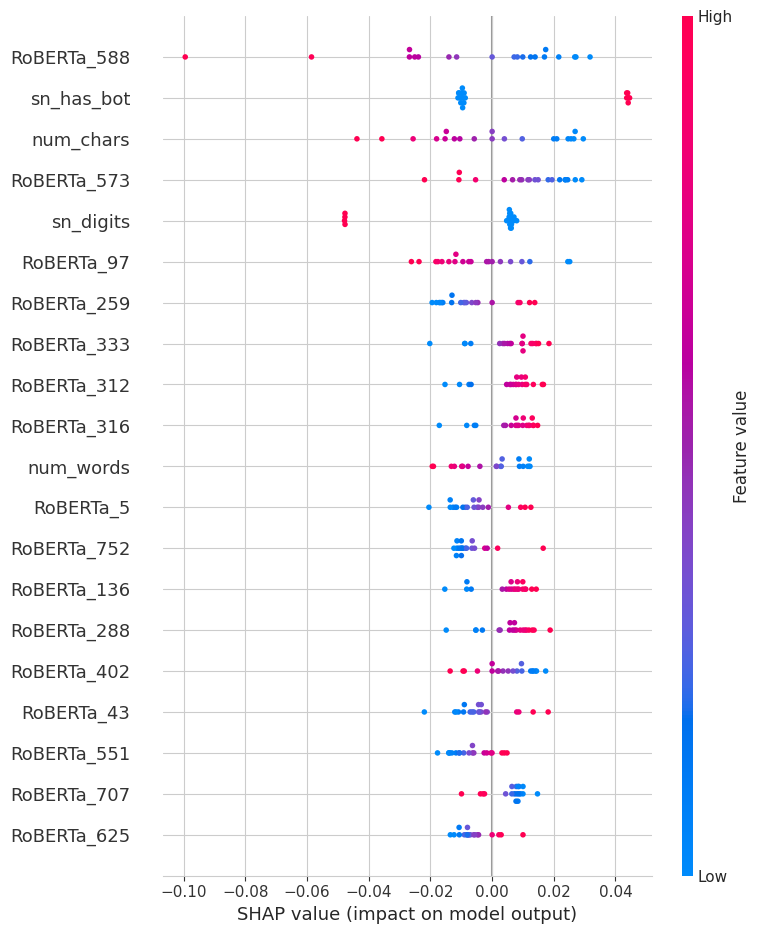

In [27]:
# --- SHAP Implementation (Corrected for CNN Input Size Error) ---
import shap
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import re

# ... (extract_manual_features function remains the same as before) ...
def extract_manual_features(df_text_col, df_screen_name_col, df_original_text_col):
    features_list = []
    # ... (full function definition) ...
    for text_cleaned, screen_name, text_original in zip(df_text_col, df_screen_name_col, df_original_text_col):
        raw_text = str(text_original); num_urls = len(re.findall(r'http\\S+', raw_text))
        num_mentions = len(re.findall(r'@\\w+', raw_text)); num_hashtags = len(re.findall(r'#\\w+', raw_text))
        words = str(text_cleaned).split(); num_words = len(words); num_characters = len(str(text_cleaned))
        avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        num_digits_text = sum(c.isdigit() for c in str(text_cleaned))
        num_uppercase_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        sn = str(screen_name); sn_length = len(sn); sn_num_digits = sum(c.isdigit() for c in sn)
        sn_has_bot = 1 if 'bot' in sn.lower() else 0
        features_list.append([
            num_characters, num_words, avg_word_length, num_urls, num_mentions, num_hashtags,
            num_digits_text, num_uppercase_words, sn_length, sn_num_digits, sn_has_bot
        ])
    return np.array(features_list)

# --- 1. Create a MODIFIED "SHAP-friendly" model wrapper ---
# This version BYPASSES the CNN layers, as they cannot operate on the [CLS] token summary.
# It connects the RoBERTa embedding and extra features directly to a new classifier layer.
class ShapModelWrapper(nn.Module):
    def __init__(self, original_model):
        super(ShapModelWrapper, self).__init__()
        # The input to this new classifier will be the RoBERTa [CLS] embedding + extra features
        roberta_dim = 768
        extra_features_dim = original_model.classifier.in_features - 300 # 300 is the CNN output size (100 filters * 3 kernels)
        
        # We need a new final layer for this simplified explanation model.
        # We can't reuse the original classifier because the input shape is different.
        self.new_classifier = nn.Linear(roberta_dim + extra_features_dim, 2)
        
    def forward(self, x):
        # x is a NumPy array, convert it to a tensor
        x_tensor = torch.from_numpy(x).float().to(device)
        
        # Here, the entire input 'x' is the concatenated vector.
        # We pass it directly to our new classifier.
        logits = self.new_classifier(x_tensor)
        
        return logits.detach().cpu().numpy()

# Instantiate the wrapper. Note it's a simplified model for explanation purposes.
shap_model = ShapModelWrapper(model_roberta_cnn_extra).to(device)
shap_model.eval()

# --- 2. Prepare the Data for SHAP ---
def get_model_inputs(df):
    model_roberta_cnn_extra.eval()
    extra_features = extract_manual_features(df['processed_text'], df['screen_name'], df['text'])
    scaled_extra_features = scaler.transform(extra_features)
    roberta_embeddings = []
    with torch.no_grad():
        for text in tqdm(df['processed_text'], desc="Getting RoBERTa Embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            embedding = model_roberta_cnn_extra.roberta(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
            roberta_embeddings.append(embedding)
    roberta_embeddings = np.vstack(roberta_embeddings)
    final_input = np.hstack([roberta_embeddings, scaled_extra_features])
    return final_input

dataset_path = '/kaggle/input/tweepfakemsnew' 
df_test = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')
df_test['processed_text'] = df_test['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9@#\' ]+', '', str(x).lower().strip()))
df_test_sample = df_test.sample(100, random_state=42)
df_explain_sample = df_test.sample(20, random_state=0)

background_data_np = get_model_inputs(df_test_sample)
explain_data_np = get_model_inputs(df_explain_sample)

# --- 3. Create the SHAP Explainer and get values ---
# We use the KernelExplainer on our simplified wrapper model
explainer = shap.KernelExplainer(shap_model, background_data_np)

print("\nCalculating SHAP values... (this may take a while)")
shap_values = explainer.shap_values(explain_data_np)
print("SHAP values calculated.")

# --- 4. Visualize the results ---
roberta_feature_names = [f'RoBERTa_{i}' for i in range(768)]
extra_feature_names = [
    'num_chars', 'num_words', 'avg_word_len', 'num_urls', 'num_mentions', 'num_hashtags',
    'num_digits', 'num_uppercase', 'sn_len', 'sn_digits', 'sn_has_bot'
]
all_feature_names = roberta_feature_names + extra_feature_names

print("\n--- Generating SHAP Global Feature Importance Plot ---")
# This plot will now clearly show the importance of your 11 extra features
# relative to the RoBERTa text summary features.
shap.summary_plot(shap_values[1], features=explain_data_np, feature_names=all_feature_names, max_display=20)

In [29]:
df_test.head()

,screen_name,text,account.type,class_type,processed_text
0,zawvrk,justin timberlake really one of the goats if y...,human,human,justin timberlake really one of the goats if y...
1,narendramodi,Thank you @PMBhutan for your gracious prayers ...,human,human,thank you @pmbhutan for your gracious prayers ...
2,ahadsheriff,Theory: the number of red lights you will hit ...,human,human,theory the number of red lights you will hit w...
3,AINarendraModi,Respects on the Upt of the I good with the peo...,bot,rnn,respects on the upt of the i good with the peo...
4,kevinhooke,Might give the BASIC #10Liner game contest ano...,human,human,might give the basic #10liner game contest ano...



--- Starting Fine-Grained AI Model Detection Analysis ---
Unique classes for multi-class analysis: ['gpt2', 'human', 'others', 'rnn']


Making binary predictions on the test set:   0%|          | 0/160 [00:00<?, ?it/s]

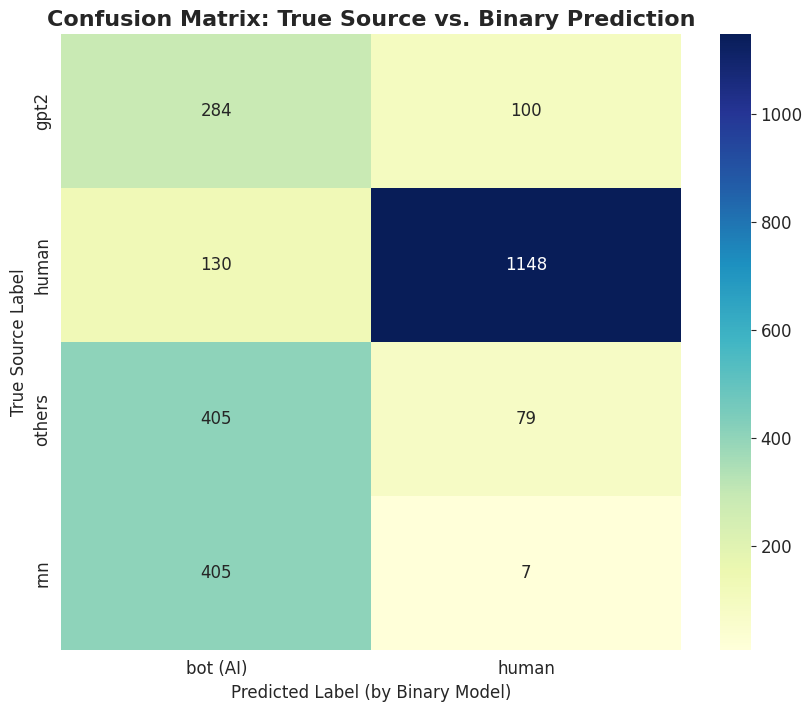


--- Detailed Classification Report ---

              precision    recall  f1-score   support

    bot (AI)       0.89      0.85      0.87      1280
       human       0.86      0.90      0.88      1278

    accuracy                           0.88      2558
   macro avg       0.88      0.88      0.88      2558
weighted avg       0.88      0.88      0.88      2558


--- Accuracy per AI Generator Source ---
Detection accuracy for 'gpt2': 73.96%
Detection accuracy for 'others': 83.68%
Detection accuracy for 'rnn': 98.30%


In [31]:
# --- SECTION 5: FINE-GRAINED MULTI-CLASS DETECTION ANALYSIS ---
# This section addresses the model's ability to detect tweets from different AI generators.

from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

print("\n--- Starting Fine-Grained AI Model Detection Analysis ---")

# --- 1. Load and Prepare the Full Test Set ---
# We'll use df_test which should already be loaded. If not, this is a safeguard.
try:
    df_test
except NameError:
    print("Reloading test data...")
    dataset_path = '/kaggle/input/tweepfakemsnew' # Make sure path is correct
    df_test = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')
    # Basic preprocessing from your original notebook
    def clean_text(text):
        text = str(text); text = re.sub(r'http\\S+', '', text)
        text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text); text = text.lower().strip()
        return text
    df_test['processed_text'] = df_test['text'].apply(clean_text)

# --- 2. Create the true labels for the multi-class problem ---
# The 'source' column contains the AI model name. For humans, it's NaN.
# We'll fill NaN with 'human' to create a single ground truth column.
df_test['ground_truth_source'] = df_test['class_type'].fillna('human')
all_true_labels = df_test['ground_truth_source']
# Get a sorted list of all unique ground truth classes
class_names = sorted(df_test['ground_truth_source'].unique())

print(f"Unique classes for multi-class analysis: {class_names}")

# --- 3. Run Predictions with your Best Binary Model ---
# This logic is similar to the performance-by-generator plot, but for the whole test set.
model_roberta_cnn_extra.eval()

# Create a full dataloader for the test set
test_encodings = tokenizer(list(df_test['processed_text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_extra_features = extract_manual_features(df_test['processed_text'], df_test['screen_name'], df_test['text'])
test_extra_features_scaled = scaler.transform(test_extra_features)
# Note: we don't need the labels for prediction, so we just create a dataset of inputs
test_dataset_for_pred = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_extra_features_scaled, dtype=torch.float))
test_dataloader_for_pred = DataLoader(test_dataset_for_pred, batch_size=16)

all_binary_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader_for_pred, desc="Making binary predictions on the test set"):
        input_ids, attention_mask, extra_feats = [b.to(device) for b in batch]
        logits = model_roberta_cnn_extra(input_ids, attention_mask, extra_feats)["logits"]
        preds = torch.argmax(logits, dim=1)
        all_binary_preds.extend(preds.cpu().numpy())

# Convert binary predictions (0 or 1) into multi-class labels for the confusion matrix
# If the model predicts 0, we label it 'human'. If it predicts 1, we label it 'bot (AI)'.
# This allows us to see how the detailed ground truth aligns with the binary output.
predicted_labels = ['human' if p == 0 else 'bot (AI)' for p in all_binary_preds]
# Define the order of labels for the confusion matrix for clarity
matrix_labels = ['human', 'bot (AI)']

# --- 4. Generate and Visualize the Multi-class Confusion Matrix ---
# Note: The y-axis will have your detailed sources, the x-axis has the binary prediction.
cm = confusion_matrix(all_true_labels, predicted_labels, labels=class_names + ['bot (AI)'])
# We need to reshape the confusion matrix to be correct
cm_df = pd.crosstab(all_true_labels, pd.Series(predicted_labels, name='Predicted'), rownames=['True'])


plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix: True Source vs. Binary Prediction', fontsize=16, weight='bold')
plt.ylabel('True Source Label', fontsize=12)
plt.xlabel('Predicted Label (by Binary Model)', fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, "fig_multiclass_confusion_matrix.png"))
plt.show()

# --- 5. Print a Detailed Classification Report ---
# This report is more intuitive as it directly shows precision/recall for each generator
print("\n--- Detailed Classification Report ---\n")
# We modify the true labels to match the binary nature of the prediction for a clear report
true_binary_labels = ['human' if label == 'human' else 'bot (AI)' for label in all_true_labels]
print(classification_report(true_binary_labels, predicted_labels))

# For the fine-grained report, we can check accuracy per source again
print("\n--- Accuracy per AI Generator Source ---")
df_test['binary_prediction'] = all_binary_preds
for source_name in class_names:
    if source_name == 'human':
        continue
    
    subset_df = df_test[df_test['ground_truth_source'] == source_name]
    # We want to know how many of this source's tweets were correctly identified as bot (1)
    accuracy = (subset_df['binary_prediction'] == 1).mean()
    print(f"Detection accuracy for '{source_name}': {accuracy:.2%}")

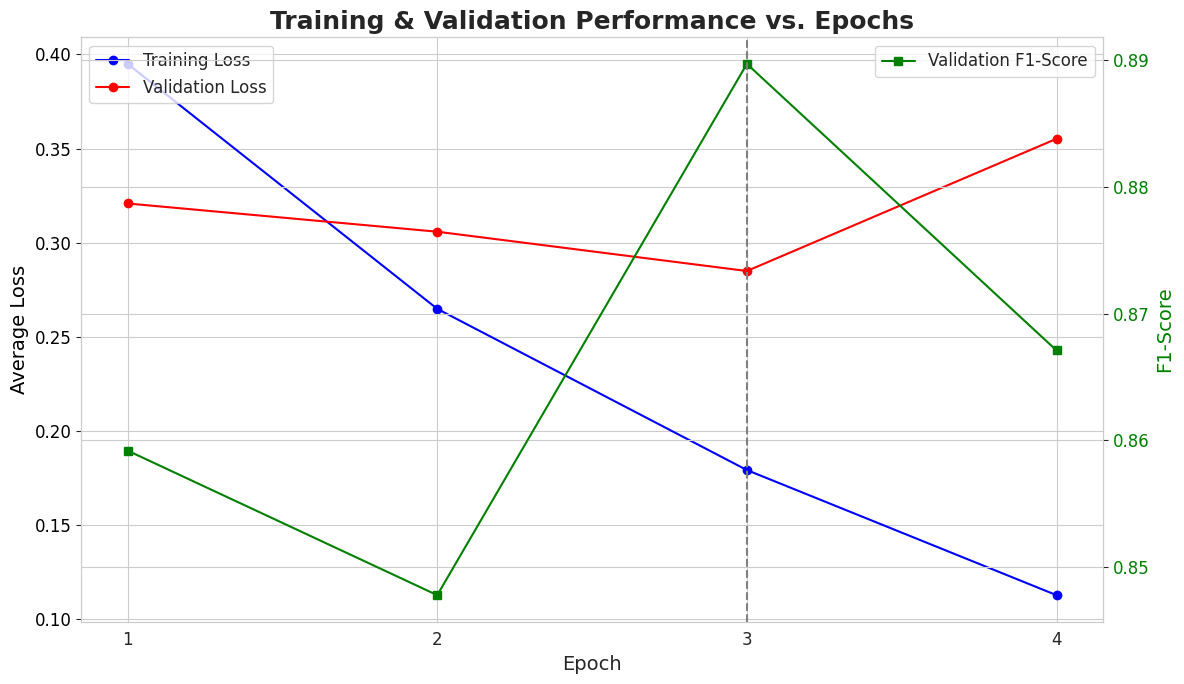

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated data from your 8-epoch run
history_data = {
    'epoch': [1, 2, 3, 4],
    'train_avg_loss': [0.3950, 0.2648, 0.1791, 0.1126],
    'val_f1_score': [0.8592, 0.8478, 0.8897, 0.8671],
    'val_avg_loss': [0.3208, 0.3058, 0.2849, 0.3552]
}
history_df = pd.DataFrame(history_data)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))
sns.set_style("whitegrid")

# Plot Loss curves
ax1.plot(history_df['epoch'], history_df['train_avg_loss'], 'b-o', label='Training Loss')
ax1.plot(history_df['epoch'], history_df['val_avg_loss'], 'r-o', label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Average Loss', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create a second y-axis for the F1 score
ax2 = ax1.twinx()
ax2.plot(history_df['epoch'], history_df['val_f1_score'], 'g-s', label='Validation F1-Score')
ax2.set_ylabel('F1-Score', fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

# Highlight the optimal epoch
plt.axvline(x=3, color='grey', linestyle='--', label='Optimal Epoch (Best Val F1)')
plt.title('Training & Validation Performance vs. Epochs', fontsize=18, weight='bold')
fig.tight_layout()
plt.xticks([1, 2, 3, 4])
#plt.savefig('training_validation_curves.png')
plt.show()